In [1]:
import pandas as pd
df = pd.read_csv('/content/AP003.csv')

df.head()

,From Date,To Date,PM2.5 (ug/m3),PM10 (ug/m3),NO (ug/m3),NO2 (ug/m3),NOx (ppb),NH3 (ug/m3),SO2 (ug/m3),CO (mg/m3),...,Temp (degree C),RH (%),WS (m/s),WD (degree),SR (W/mt2),BP (mmHg),VWS (m/s),AT (degree C),RF (mm),Xylene (ug/m3)
0,2017-07-01 00:00:00,2017-07-01 01:00:00,50.00,91.75,3.33,27.70,17.48,NaN,24.35,1.33,...,55.22,83.25,1.67,285.50,6.75,737.0,0.03,26.30,0.00,0.65
1,2017-07-01 01:00:00,2017-07-01 02:00:00,30.75,59.25,1.20,20.78,11.40,0.03,8.23,1.77,...,57.48,84.50,2.50,299.50,6.75,736.0,0.05,25.00,1.50,0.50
2,2017-07-01 02:00:00,2017-07-01 03:00:00,NaN,NaN,1.17,4.07,2.73,0.10,10.77,1.20,...,58.67,86.00,0.77,285.67,6.67,736.0,0.03,24.17,0.33,0.43
3,2017-07-01 03:00:00,2017-07-01 04:00:00,8.00,NaN,2.58,6.38,5.30,NaN,19.78,1.58,...,58.93,86.00,1.55,302.50,6.00,735.0,0.08,24.10,0.00,0.63
4,2017-07-01 04:00:00,2017-07-01 05:00:00,33.25,NaN,5.30,21.03,15.47,0.15,22.40,2.25,...,59.88,86.00,2.30,297.25,6.00,735.0,0.08,24.90,0.00,0.67


In [2]:
null_values = df.isnull().sum()

print("Null values per column:")
print(null_values)

Null values per column:
From Date             0
To Date               0
PM2.5 (ug/m3)      5709
PM10 (ug/m3)       5382
NO (ug/m3)         4148
NO2 (ug/m3)        4695
NOx (ppb)          3360
NH3 (ug/m3)        4644
SO2 (ug/m3)        6796
CO (mg/m3)         3407
Ozone (ug/m3)      5091
Benzene (ug/m3)    3722
Toluene (ug/m3)    3722
Temp (degree C)    4065
RH (%)             3880
WS (m/s)           3878
WD (degree)        5690
SR (W/mt2)         3355
BP (mmHg)          6720
VWS (m/s)          3357
AT (degree C)      4030
RF (mm)            3252
Xylene (ug/m3)     3742
dtype: int64


In [3]:
import pandas as pd

# Convert 'From Date' and 'To Date' to datetime
df['From Date'] = pd.to_datetime(df['From Date'], errors='coerce')
df['To Date'] = pd.to_datetime(df['To Date'], errors='coerce')

# Separate date columns and data columns
df_dates = df[['From Date']]
df_data = df.drop(columns=['From Date', 'To Date'])

# Get the threshold values for handling missing data
threshold_55 = len(df_data) * 0.55
threshold_20 = len(df_data) * 0.20

# Step 1: Drop columns with more than 55% missing values
df_data_cleaned = df_data.dropna(thresh=threshold_55, axis=1)

# Step 2: For columns with 20% to 55% missing values, fill with mean
columns_with_20_55_nulls = df_data_cleaned.columns[df_data_cleaned.isnull().mean() > 0.20]
columns_with_20_55_nulls = columns_with_20_55_nulls[df_data_cleaned[columns_with_20_55_nulls].isnull().mean() <= 0.55]

# Use .loc to avoid the SettingWithCopyWarning
df_data_cleaned.loc[:, columns_with_20_55_nulls] = df_data_cleaned[columns_with_20_55_nulls].fillna(df_data_cleaned[columns_with_20_55_nulls].mean())

# Step 3: For columns with less than 20% missing values, use linear interpolation
columns_with_less_20_nulls = df_data_cleaned.columns[df_data_cleaned.isnull().mean() <= 0.20]

# Again, use .loc for setting values
df_data_cleaned.loc[:, columns_with_less_20_nulls] = df_data_cleaned[columns_with_less_20_nulls].interpolate(method='linear', inplace=False)

# Handle object type columns (non-numeric)
for column in df_data_cleaned.select_dtypes(include=['object']).columns:
    df_data_cleaned.loc[:, column] = df_data_cleaned[column].fillna(df_data_cleaned[column].mode()[0])

# Drop remaining rows with any NaN values
df_data_cleaned.dropna(inplace=True)

# Re-add 'From Date' column to cleaned data
df_cleaned = pd.concat([df_dates, df_data_cleaned], axis=1)

# Set 'From Date' as index for resampling
df_cleaned.set_index('From Date', inplace=True)

# Separate numeric and non-numeric columns
df_numeric = df_cleaned.select_dtypes(include=['number'])
df_non_numeric = df_cleaned.select_dtypes(exclude=['number'])

# Resample numeric columns by day and calculate the mean
df_daily_numeric = df_numeric.resample('D').mean()

# Resample non-numeric columns and forward-fill missing values
df_non_numeric_daily = df_non_numeric.resample('D').ffill()

# Combine resampled numeric and non-numeric data
df_daily = pd.concat([df_daily_numeric, df_non_numeric_daily], axis=1)

# Reset index to move 'From Date' back to a column
df_daily.reset_index(inplace=True)

# Add 'Weekday' column based on 'From Date'
df_daily['Weekday'] = df_daily['From Date'].dt.day_name()

# Move 'Weekday' column next to 'From Date'
from_date_col_index = df_daily.columns.get_loc('From Date')
df_daily.insert(from_date_col_index + 1, 'Weekday', df_daily.pop('Weekday'))

df_daily.insert(1, 'City', 'Tirupathi')

# Step 1: Calculate the sum of the pollutants for each row
df_daily['Pollutant Sum'] = (
    df_daily['PM2.5 (ug/m3)'] +
    df_daily['PM10 (ug/m3)'] +
    df_daily['NO (ug/m3)'] +
    df_daily['NO2 (ug/m3)'] +
    (df_daily['NOx (ppb)'] * 1.88) +  # Convert NOx to µg/m³ if necessary
    df_daily['NH3 (ug/m3)']
)

# Step 2: Calculate the mean of the pollutant sums (mean per row)
mean_value = df_daily['Pollutant Sum'] / 6

# Step 3: Define a function to classify air quality level
def classify_air_quality(mean_value):
    if mean_value <= 50:
        return "Good"
    elif 51 <= mean_value <= 100:
        return "Moderate"
    elif 101 <= mean_value <= 150:
        return "Poor"
    elif 151 <= mean_value <= 200:
        return "Unhealthy"
    elif 201 <= mean_value <= 300:
        return "Very Unhealthy"
    else:
        return "Hazardous"

# Step 4: Classify the Air Quality Level based on the mean value
# Use apply to classify for each row
df_daily['Air Quality Level'] = mean_value.apply(classify_air_quality)
df_daily.drop(columns=['Pollutant Sum'], inplace=True)
# Display the cleaned and processed DataFrame
print("Cleaned and Daily Resampled DataFrame with Weekday, City, and Air Quality Level:")
print(df_daily.head())

# Save the cleaned data to a new CSV file
output_path = 'Tirupathi.csv'
df_daily.to_csv(output_path, index=False)

print(f"Updated data saved to {output_path}")


Cleaned and Daily Resampled DataFrame with Weekday, City, and Air Quality Level:
   From Date       City    Weekday  PM2.5 (ug/m3)  PM10 (ug/m3)  NO (ug/m3)  \
0 2017-07-01  Tirupathi   Saturday      36.729762     74.188836    3.798571   
1 2017-07-02  Tirupathi     Sunday      40.610833    110.892500    2.987083   
2 2017-07-03  Tirupathi     Monday      43.542083    105.925625    3.497708   
3 2017-07-04  Tirupathi    Tuesday      46.322917    122.885833    3.188333   
4 2017-07-05  Tirupathi  Wednesday      49.722083    128.597083    3.411667   

   NO2 (ug/m3)  NOx (ppb)  NH3 (ug/m3)  SO2 (ug/m3)  ...     RH (%)  WS (m/s)  \
0    16.662857  11.702857     6.245238    18.132143  ...  81.016667  1.788571   
1    15.260833  10.546667     3.825000    14.087500  ...  80.003750  1.937083   
2    19.253333  13.070000     4.421250    13.851042  ...  76.125417  1.846250   
3    16.335833  11.272917     5.003750    14.704375  ...  71.562083  1.849583   
4    17.075833  11.840833     4.690000 

In [4]:
import pandas as pd
df = pd.read_csv('/content/Tirupathi.csv')

null_values = df.isnull().sum()
print("Null values per column:")
print(null_values)
df.head()

Null values per column:
From Date            0
City                 0
Weekday              0
PM2.5 (ug/m3)        0
PM10 (ug/m3)         0
NO (ug/m3)           0
NO2 (ug/m3)          0
NOx (ppb)            0
NH3 (ug/m3)          0
SO2 (ug/m3)          0
CO (mg/m3)           0
Ozone (ug/m3)        0
Benzene (ug/m3)      0
Toluene (ug/m3)      0
Temp (degree C)      0
RH (%)               0
WS (m/s)             0
WD (degree)          0
SR (W/mt2)           0
BP (mmHg)            0
VWS (m/s)            0
AT (degree C)        0
RF (mm)              0
Xylene (ug/m3)       0
Air Quality Level    0
dtype: int64


,From Date,City,Weekday,PM2.5 (ug/m3),PM10 (ug/m3),NO (ug/m3),NO2 (ug/m3),NOx (ppb),NH3 (ug/m3),SO2 (ug/m3),...,RH (%),WS (m/s),WD (degree),SR (W/mt2),BP (mmHg),VWS (m/s),AT (degree C),RF (mm),Xylene (ug/m3),Air Quality Level
0,2017-07-01,Tirupathi,Saturday,36.729762,74.188836,3.798571,16.662857,11.702857,6.245238,18.132143,...,81.016667,1.788571,293.412857,88.003810,735.083810,0.087143,26.381905,0.005714,2.809524,Good
1,2017-07-02,Tirupathi,Sunday,40.610833,110.892500,2.987083,15.260833,10.546667,3.825000,14.087500,...,80.003750,1.937083,282.448333,80.496250,736.382500,0.090833,26.317083,0.022500,2.088333,Good
2,2017-07-03,Tirupathi,Monday,43.542083,105.925625,3.497708,19.253333,13.070000,4.421250,13.851042,...,76.125417,1.846250,283.203125,86.637292,737.864583,0.080000,27.819167,0.012083,3.075833,Good
3,2017-07-04,Tirupathi,Tuesday,46.322917,122.885833,3.188333,16.335833,11.272917,5.003750,14.704375,...,71.562083,1.849583,273.535000,147.350417,736.982500,0.095000,30.542083,0.000000,2.885417,Good
4,2017-07-05,Tirupathi,Wednesday,49.722083,128.597083,3.411667,17.075833,11.840833,4.690000,13.696042,...,68.274583,1.689583,279.912917,136.062500,736.291667,0.082500,32.282500,0.000000,2.607917,Good


In [5]:
import pandas as pd

expected_dtypes = {
    'From Date' : 'object',
    'City' : 'object',
    'Weekday' : 'object',
    'PM2.5 (ug/m3)' : 'float64',
    'PM10 (ug/m3)' : 'float64',
    'NO (ug/m3)' : 'float64',
    'NO2 (ug/m3)' : 'float64',
    'NOx (ppb)' : 'float64',
    'NH3 (ug/m3)' : 'float64',
    'SO2 (ug/m3)' : 'float64',
    'CO (mg/m3)' : 'float64',
    'Ozone (ug/m3)' : 'float64',
    'Benzene (ug/m3)' : 'float64',
    'Eth-Benzene (ug/m3)' : 'float64',
    'MP-Xylene (ug/m3)' : 'float64',
    'RH (%)' : 'float64',
    'WS (m/s)' : 'float64',
    'WD (degree)' : 'float64',
    'SR (W/mt2)' : 'float64',
    'BP (mmHg)' : 'float64',
    'AT (degree C)' : 'float64',
    'RF (mm)' : 'float64',
    'Xylene (ug/m3)' : 'float64',
    'O Xylene (ug/m3)' : 'float64',
    'Air Quality Level' : 'object'
}
for column in df.columns:
  actual_dtype = str(df[column].dtype)
  expected_dtype = expected_dtypes.get(column)
  if expected_dtype:
        if actual_dtype == expected_dtype:
            print(f"Feature '{column}' has the correct datatype: {actual_dtype}")
        else:
            print(f"Feature '{column}' has incorrect datatype: {actual_dtype}, expected: {expected_dtype}")
  else:
    print(f"No expected datatype provided for feature '{column}'")

Feature 'From Date' has the correct datatype: object
Feature 'City' has the correct datatype: object
Feature 'Weekday' has the correct datatype: object
Feature 'PM2.5 (ug/m3)' has the correct datatype: float64
Feature 'PM10 (ug/m3)' has the correct datatype: float64
Feature 'NO (ug/m3)' has the correct datatype: float64
Feature 'NO2 (ug/m3)' has the correct datatype: float64
Feature 'NOx (ppb)' has the correct datatype: float64
Feature 'NH3 (ug/m3)' has the correct datatype: float64
Feature 'SO2 (ug/m3)' has the correct datatype: float64
Feature 'CO (mg/m3)' has the correct datatype: float64
Feature 'Ozone (ug/m3)' has the correct datatype: float64
Feature 'Benzene (ug/m3)' has the correct datatype: float64
No expected datatype provided for feature 'Toluene (ug/m3)'
No expected datatype provided for feature 'Temp (degree C)'
Feature 'RH (%)' has the correct datatype: float64
Feature 'WS (m/s)' has the correct datatype: float64
Feature 'WD (degree)' has the correct datatype: float64
Fea

In [6]:

ranges = {
    'PM2.5 (ug/m3)': (0,12),
    'PM10 (ug/m3)' : (0,54),
    'NO (ug/m3)' : (0,40),
    'NO2 (ug/m3)' : (0,40),
    'NOx (ppb)' : (0,54),
    'SO2 (ug/m3)' : (0,20),
    'CO (mg/m3)' : (0,10),
    'Ozone (ug/m3)' : (0,100),
    'Benzene (ug/m3)' : (0,5),
    'Eth-Benzene (ug/m3)' : (0,5),
    'MP-Xylene (ug/m3)' : (0,5),
    'RH (%)' : (30,60),
    'WS (m/s)' : (0,5),
    'WD (degree)' : (0,360),
    'SR (W/mt2)' : (0,1200),
    'BP (mmHg)' : (700,800),
    'AT (degree C)' : (-10,50),
    'RF (mm)' : (0,100),
    'Xylene (ug/m3)' : (3,390)
}

for column in ranges:
    if column in df.columns:
        min_val, max_val = ranges[column]
        print(f"Checking column: {column}")
        for value in df[column]:
            if pd.notnull(value):
                if value < min_val or value > max_val:
                    print(f"Value {value} is outside the specified range for column {column}")
                else:
                    print(f"Value {value} is within the specified range for column {column}")
    else:
        print(f"Column {column} not found in DataFrame.")


Streaming output truncated to the last 5000 lines.
Value 24.4725 is within the specified range for column AT (degree C)
Value 24.73375 is within the specified range for column AT (degree C)
Value 24.28 is within the specified range for column AT (degree C)
Value 24.25583333333333 is within the specified range for column AT (degree C)
Value 25.06125 is within the specified range for column AT (degree C)
Value 24.844583333333333 is within the specified range for column AT (degree C)
Value 25.47458333333333 is within the specified range for column AT (degree C)
Value 24.60935606060606 is within the specified range for column AT (degree C)
Value 25.50314393939394 is within the specified range for column AT (degree C)
Value 23.7825 is within the specified range for column AT (degree C)
Value 23.987916666666667 is within the specified range for column AT (degree C)
Value 23.18458333333333 is within the specified range for column AT (degree C)
Value 22.35291666666667 is within the specified r

Variance for each numeric column:
PM2.5 (ug/m3)       801.082671
PM10 (ug/m3)       2956.350210
NO (ug/m3)          198.791469
NO2 (ug/m3)         251.550848
NOx (ppb)           290.712769
NH3 (ug/m3)         143.575990
SO2 (ug/m3)          45.259884
CO (mg/m3)            0.126177
Ozone (ug/m3)       603.462475
Benzene (ug/m3)       4.315544
Toluene (ug/m3)      59.273525
Temp (degree C)      10.009727
RH (%)               51.534096
WS (m/s)              0.716811
WD (degree)        2667.022037
SR (W/mt2)         2626.413381
BP (mmHg)           100.284199
VWS (m/s)             0.002274
AT (degree C)        14.587748
RF (mm)               0.010943
Xylene (ug/m3)       26.555010
dtype: float64


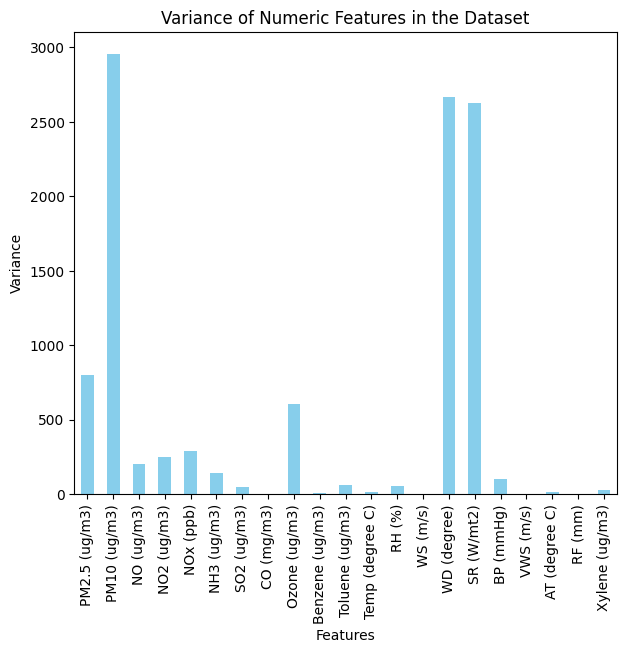

In [7]:
df = df.select_dtypes(include=['number'])

variance = df.var()
print("Variance for each numeric column:")
print(variance)

import matplotlib.pyplot as plt

#bar graph
plt.figure(figsize=(7, 6))
variance.plot(kind='bar', color='skyblue')
plt.title('Variance of Numeric Features in the Dataset')
plt.xlabel('Features')
plt.ylabel('Variance')

plt.show()


Normalized Variance for each numeric column (range 1-10):
PM2.5 (ug/m3)       3.438726
PM10 (ug/m3)       10.000000
NO (ug/m3)          1.605173
NO2 (ug/m3)         1.765788
NOx (ppb)           1.885009
NH3 (ug/m3)         1.437081
SO2 (ug/m3)         1.137778
CO (mg/m3)          1.000377
Ozone (ug/m3)       2.837112
Benzene (ug/m3)     1.013131
Toluene (ug/m3)     1.180439
Temp (degree C)     1.030466
RH (%)              1.156878
WS (m/s)            1.002175
WD (degree)         9.119199
SR (W/mt2)          8.995574
BP (mmHg)           1.305288
VWS (m/s)           1.000000
AT (degree C)       1.044403
RF (mm)             1.000026
Xylene (ug/m3)      1.080834
dtype: float64


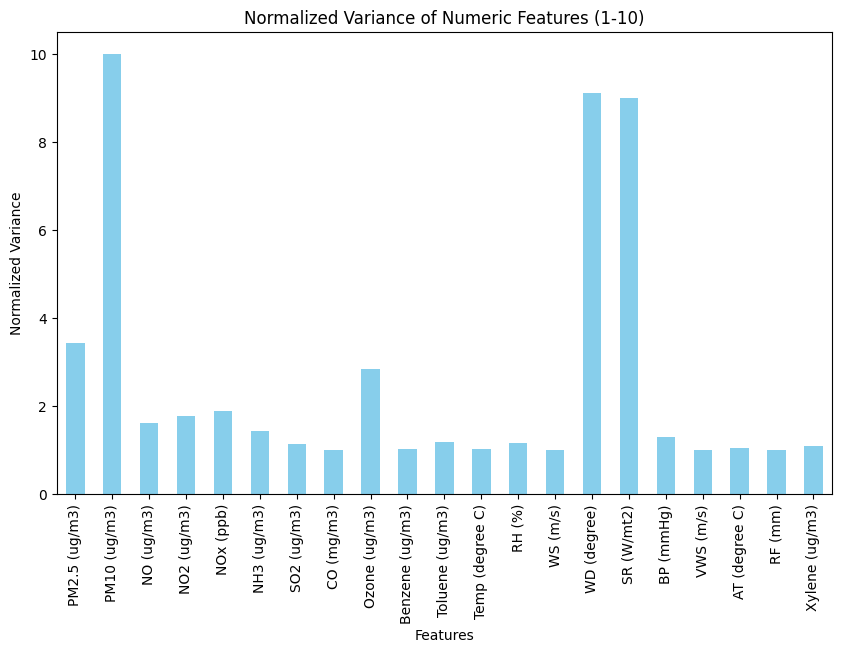

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

df_numeric = df.select_dtypes(include=['number'])
variance = df_numeric.var()

# using min-max normalization
normalized_variance = 1 + (variance - variance.min()) * 9 / (variance.max() - variance.min())


print("Normalized Variance for each numeric column (range 1-10):")
print(normalized_variance)


plt.figure(figsize=(10, 6))
normalized_variance.plot(kind='bar', color='skyblue')
plt.title('Normalized Variance of Numeric Features (1-10)')
plt.xlabel('Features')
plt.ylabel('Normalized Variance')

plt.show()


<Figure size 1000x600 with 0 Axes>

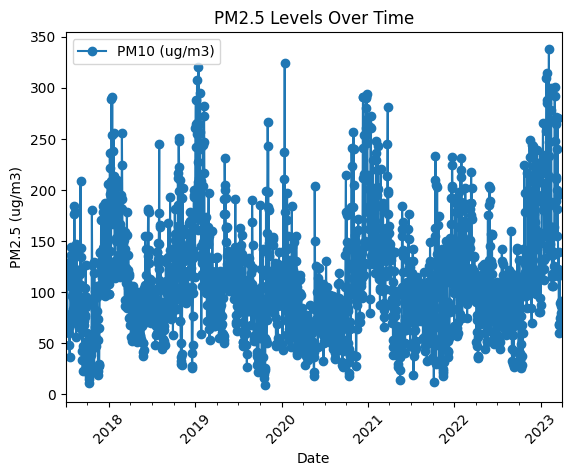

In [9]:
plt.figure(figsize=(10, 6))
df_daily.plot(x='From Date', y='PM10 (ug/m3)', kind='line', marker='o')
plt.title('PM2.5 Levels Over Time')
plt.ylabel('PM2.5 (ug/m3)')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.show()


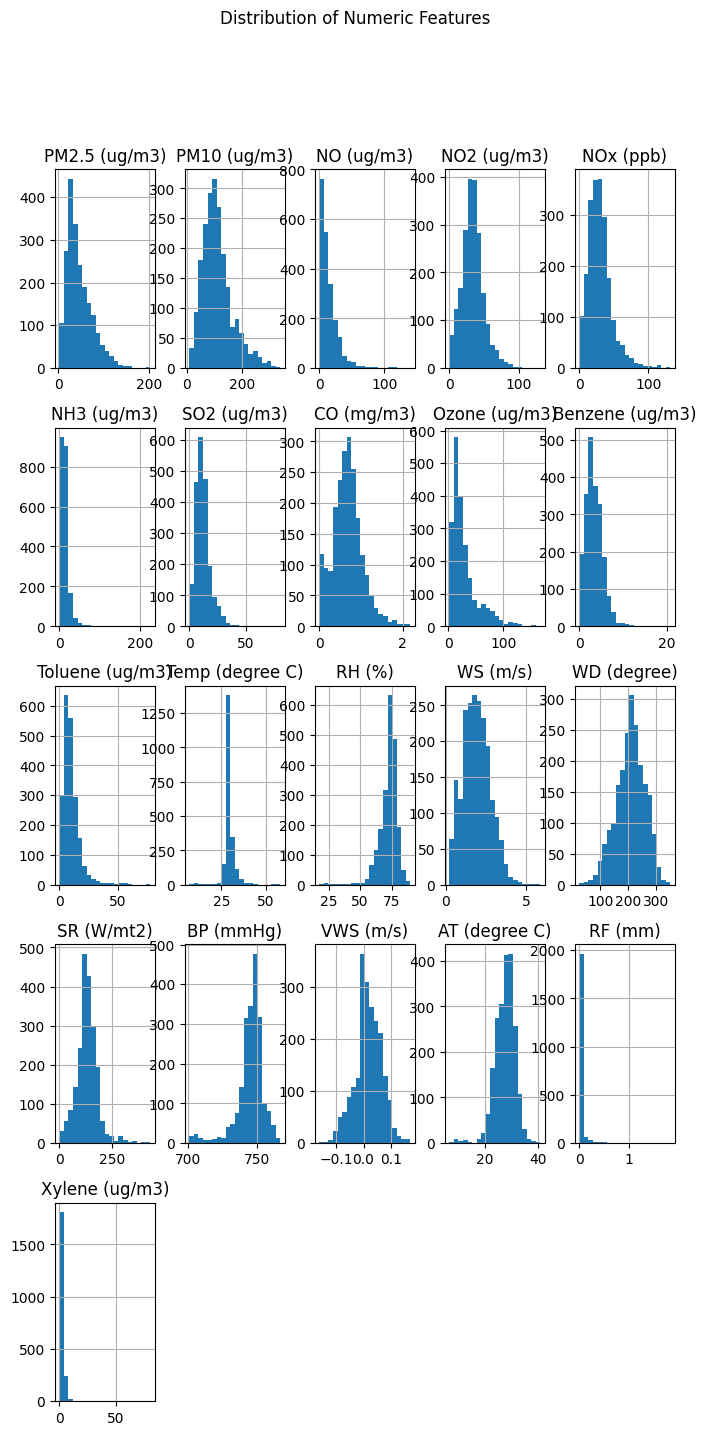

In [10]:
df_numeric.hist(bins=20, figsize=(8, 16))
plt.suptitle('Distribution of Numeric Features')
plt.show()

Total pollutant levels:
PM2.5 (ug/m3)       96761.542679
PM10 (ug/m3)       232821.246336
NO (ug/m3)          30338.932738
NO2 (ug/m3)         71464.569940
NOx (ppb)           62111.441399
NH3 (ug/m3)         29167.713571
SO2 (ug/m3)         25485.804435
CO (mg/m3)           1413.748155
Ozone (ug/m3)       62252.894613
Benzene (ug/m3)      7125.812381
Toluene (ug/m3)     20915.811339
dtype: float64


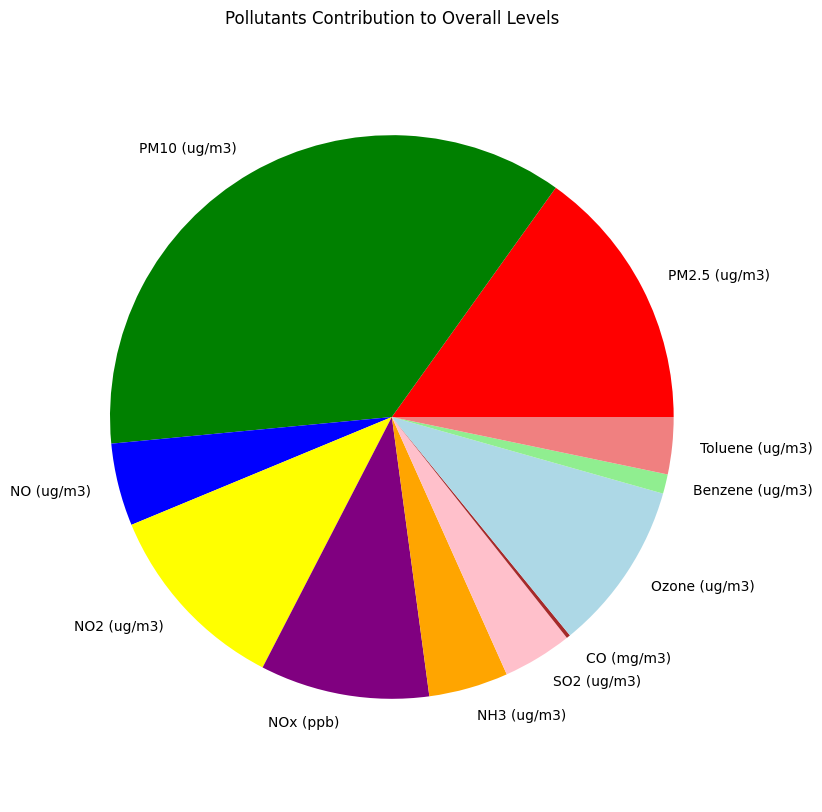

In [11]:

import pandas as pd
import matplotlib.pyplot as plt

# List of pollutants
pollutants = ['PM2.5 (ug/m3)', 'PM10 (ug/m3)', 'NO (ug/m3)', 'NO2 (ug/m3)',
              'NOx (ppb)', 'NH3 (ug/m3)', 'SO2 (ug/m3)', 'CO (mg/m3)',
              'Ozone (ug/m3)', 'Benzene (ug/m3)', 'Toluene (ug/m3)',
              'Eth-Benzene (ug/m3)', 'MP-Xylene (ug/m3)', 'O Xylene (ug/m3)']

# Filter to include only existing columns
existing_pollutants = [p for p in pollutants if p in df.columns]

# Calculate the sum of each pollutant column
pollutant_sums = df[existing_pollutants].sum()

# Display the total sum for each pollutant
print("Total pollutant levels:")
print(pollutant_sums)

# Update color palette using simple color names
colors = ['red', 'green', 'blue', 'yellow', 'purple', 'orange',
          'pink', 'brown', 'lightblue', 'lightgreen',
          'lightcoral', 'gold', 'cyan', 'magenta']

# Plot a pie chart to show which pollutants contribute the most
plt.figure(figsize=(8, 10))
plt.pie(pollutant_sums, labels=existing_pollutants, colors=colors)
plt.title('Pollutants Contribution to Overall Levels')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()


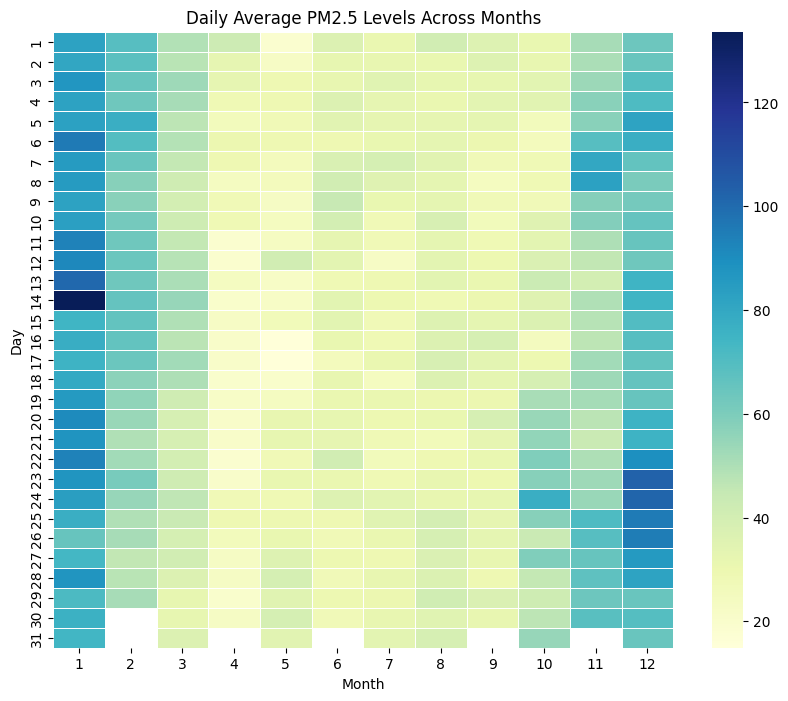

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('/content/Tirupathi.csv')

df['From Date'] = pd.to_datetime(df['From Date'], errors='coerce')

df.set_index('From Date', inplace=True)

pollutants = ['PM2.5 (ug/m3)', 'PM10 (ug/m3)', 'NO (ug/m3)', 'NO2 (ug/m3)',
              'NOx (ppb)', 'NH3 (ug/m3)', 'SO2 (ug/m3)', 'CO (mg/m3)',
              'Ozone (ug/m3)', 'Benzene (ug/m3)', 'Eth-Benzene (ug/m3)', 'MP-Xylene (ug/m3)']

existing_pollutants = [p for p in pollutants if p in df.columns]

if len(existing_pollutants) > 0:
    df['Month'] = df.index.month
    df['Day'] = df.index.day

    df_daily_avg = df[existing_pollutants].resample('D').mean()

    df_daily_avg['Month'] = df.index.month
    df_daily_avg['Day'] = df.index.day

    df_grouped = df_daily_avg.groupby(['Month', 'Day']).mean().reset_index()

    df_pivot = df_grouped.pivot(index='Day', columns='Month', values='PM2.5 (ug/m3)')

    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(df_pivot, cmap='YlGnBu',linewidths=0.5)
    plt.title('Daily Average PM2.5 Levels Across Months')
    plt.xlabel('Month')
    plt.ylabel('Day')
    plt.show()
else:
    print("None of the specified pollutant columns are present in the DataFrame.")


Correlation matrix:
                 PM2.5 (ug/m3)  PM10 (ug/m3)  NO (ug/m3)  NO2 (ug/m3)  \
PM2.5 (ug/m3)         1.000000      0.880284    0.320093     0.484552   
PM10 (ug/m3)          0.880284      1.000000    0.459580     0.596718   
NO (ug/m3)            0.320093      0.459580    1.000000     0.421730   
NO2 (ug/m3)           0.484552      0.596718    0.421730     1.000000   
NOx (ppb)             0.459827      0.606047    0.888083     0.785584   
NH3 (ug/m3)           0.161130      0.192009    0.120826     0.205676   
SO2 (ug/m3)           0.158195      0.144873    0.117830     0.161965   
CO (mg/m3)            0.522100      0.523921    0.411797     0.495540   
Ozone (ug/m3)         0.478212      0.283862   -0.108476     0.054695   
Benzene (ug/m3)       0.359820      0.397483    0.268213     0.387926   
Toluene (ug/m3)       0.156592      0.225411    0.337492     0.291408   
Temp (degree C)      -0.063867     -0.062758   -0.057971     0.063792   
RH (%)               -0.213227 

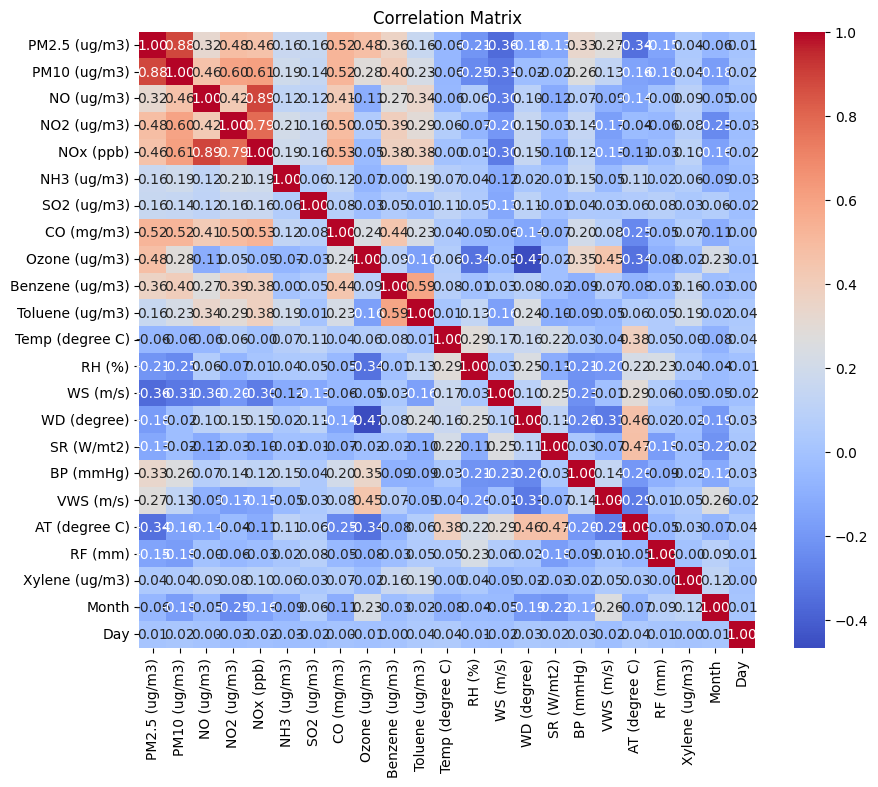

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_numeric = df.select_dtypes(include=['number'])
corr_matrix = df_numeric.corr()

print("Correlation matrix:")
print(corr_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Matrix')
plt.show()



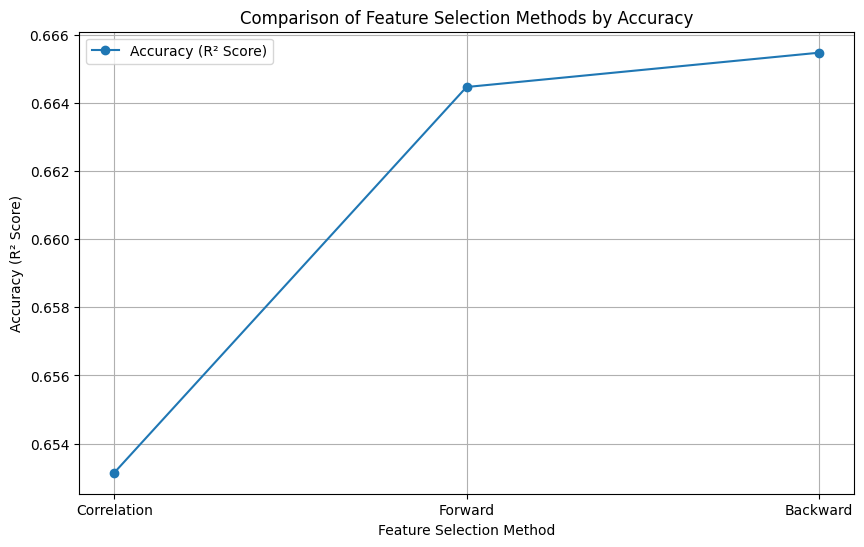

Performance of Different Feature Selection Methods:
        Method       MSE  Accuracy
0  Correlation  0.134649  0.653143
1      Forward  0.130253  0.664467
2     Backward  0.129863  0.665474

Feature Ranks for Correlation Method:
           Feature       MSE
0     PM10 (ug/m3)  0.165926
1        NOx (ppb)  0.221512
2      NO2 (ug/m3)  0.254272
3       CO (mg/m3)  0.294967
4  Benzene (ug/m3)  0.345102
5      NH3 (ug/m3)  0.355447
6         WS (m/s)  0.361629
7  Toluene (ug/m3)  0.363048

Feature Ranks for Forward Method:
         Feature       MSE
0   PM10 (ug/m3)  0.165926
1  PM2.5 (ug/m3)  0.208548
2      NOx (ppb)  0.221512
3     NO (ug/m3)  0.270320
4    NH3 (ug/m3)  0.355447
5  AT (degree C)  0.361519
6       WS (m/s)  0.361629
7         RH (%)  0.379894
8        RF (mm)  0.385516
9      VWS (m/s)  0.386281

Feature Ranks for Backward Method:
         Feature       MSE
0   PM10 (ug/m3)  0.165926
1  PM2.5 (ug/m3)  0.208548
2    NO2 (ug/m3)  0.254272
3     NO (ug/m3)  0.270320
4    

In [14]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Load your dataset and prepare features and target
X = df_daily.drop(columns=['From Date', 'City', 'Weekday', 'Air Quality Level'])
y = df_daily['Air Quality Level']


y_encoded = pd.factorize(y)[0] if y.dtype == 'object' else y

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=0)

estimator = LinearRegression()

results = {}

### 1. Correlation-Based Feature Selection ###
correlation_matrix = X.corr().abs()
target_correlation = X.corrwith(pd.Series(y_encoded)).abs()
top_features = target_correlation.sort_values(ascending=False).index[:10]

# Remove highly correlated features among selected ones
selected_features_corr = []
for feature in top_features:
    if all(correlation_matrix[feature][selected_features_corr] < 0.8):
        selected_features_corr.append(feature)

# Train and evaluate the model with correlation-based features
estimator.fit(X_train[selected_features_corr], y_train)
y_pred_corr = estimator.predict(X_test[selected_features_corr])
mse_corr = mean_squared_error(y_test, y_pred_corr)
r2_corr = r2_score(y_test, y_pred_corr)

results['Correlation'] = {'Features': selected_features_corr, 'MSE': mse_corr, 'Accuracy': r2_corr}

### 2. Forward Feature Selection ###
# Perform forward feature selection
selector_forward = SequentialFeatureSelector(estimator, n_features_to_select=10, direction='forward', scoring='r2', cv=5, n_jobs=-1)
selector_forward.fit(X_train, y_train)
selected_features_forward = X.columns[selector_forward.get_support()]

# Train and evaluate the model with forward-selected features
estimator.fit(X_train[selected_features_forward], y_train)
y_pred_forward = estimator.predict(X_test[selected_features_forward])
mse_forward = mean_squared_error(y_test, y_pred_forward)
r2_forward = r2_score(y_test, y_pred_forward)

results['Forward'] = {'Features': selected_features_forward, 'MSE': mse_forward, 'Accuracy': r2_forward}

### 3. Backward Feature Elimination ##
selector_backward = SequentialFeatureSelector(estimator, n_features_to_select=10, direction='backward', scoring='r2', cv=5, n_jobs=-1)
selector_backward.fit(X_train, y_train)
selected_features_backward = X.columns[selector_backward.get_support()]

estimator.fit(X_train[selected_features_backward], y_train)
y_pred_backward = estimator.predict(X_test[selected_features_backward])
mse_backward = mean_squared_error(y_test, y_pred_backward)
r2_backward = r2_score(y_test, y_pred_backward)

results['Backward'] = {'Features': selected_features_backward, 'MSE': mse_backward, 'Accuracy': r2_backward}

### Rank Features in Each Model Based on MSE ###
for method, data in results.items():
    feature_ranks = []
    for feature in data['Features']:
        estimator.fit(X_train[[feature]], y_train)
        y_pred_feature = estimator.predict(X_test[[feature]])
        feature_mse = mean_squared_error(y_test, y_pred_feature)
        feature_ranks.append((feature, feature_mse))

    # Rank features by individual MSE and store in results
    results[method]['Feature_Ranks'] = sorted(feature_ranks, key=lambda x: x[1])

### Convert Results to DataFrame for Visualization ###
results_df = pd.DataFrame({
    'Method': list(results.keys()),
    'MSE': [results[method]['MSE'] for method in results],
    'Accuracy': [results[method]['Accuracy'] for method in results]
})

### Plot Accuracy Comparison ###
plt.figure(figsize=(10, 6))
plt.plot(results_df['Method'], results_df['Accuracy'], marker='o', label='Accuracy (R² Score)')
plt.xlabel('Feature Selection Method')
plt.ylabel('Accuracy (R² Score)')
plt.title('Comparison of Feature Selection Methods by Accuracy')
plt.legend()
plt.grid()
plt.show()

# Display results with accuracy and MSE in tabular format
print("Performance of Different Feature Selection Methods:")
print(results_df)

# Print feature ranks for each method
for method, data in results.items():
    print(f"\nFeature Ranks for {method} Method:")
    feature_ranks_df = pd.DataFrame(data['Feature_Ranks'], columns=['Feature', 'MSE']).sort_values(by='MSE')
    print(feature_ranks_df)


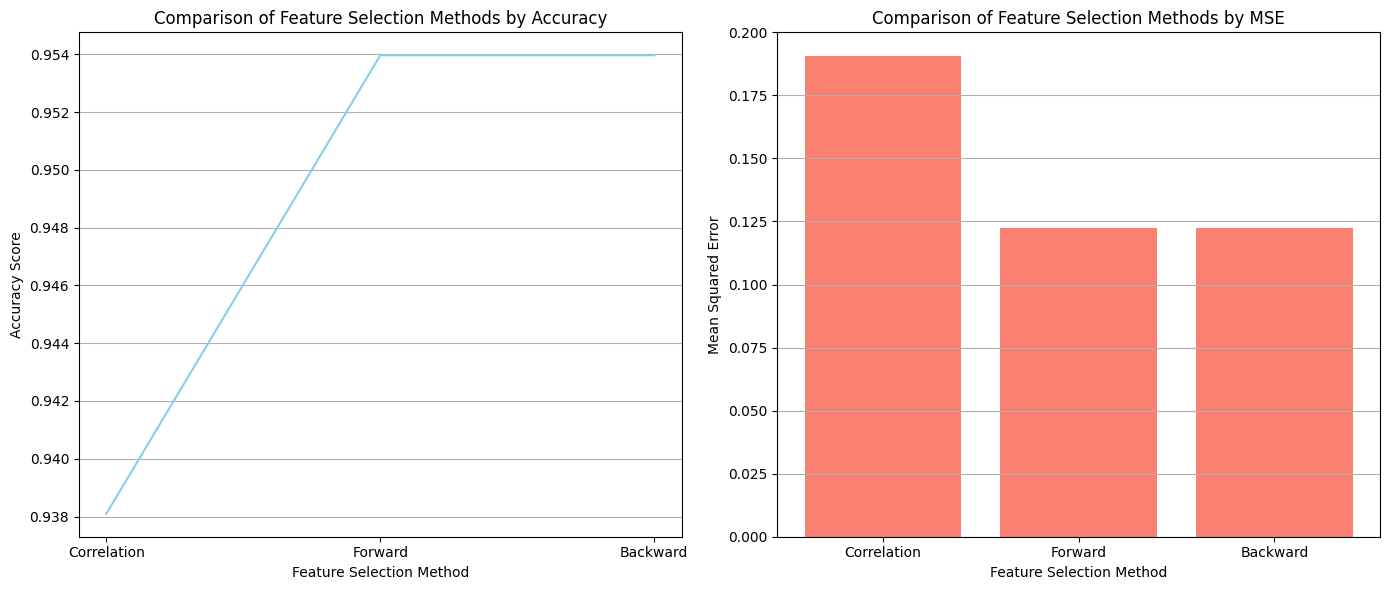

Performance of Different Feature Selection Methods:
        Method       MSE  Accuracy
0  Correlation  0.190476  0.938095
1      Forward  0.122222  0.953968
2     Backward  0.122222  0.953968

Feature Ranks for Correlation Method:
           Feature       MSE
0     PM10 (ug/m3)  0.642857
1        NOx (ppb)  0.965079
2      NO2 (ug/m3)  1.076190
3       CO (mg/m3)  1.357143
4         WS (m/s)  1.525397
5  Benzene (ug/m3)  1.576190
6  Toluene (ug/m3)  1.671429
7      NH3 (ug/m3)  1.714286

Feature Ranks for Forward Method:
          Feature       MSE
0    PM10 (ug/m3)  0.642857
1   PM2.5 (ug/m3)  0.780952
2       NOx (ppb)  0.965079
3     NO2 (ug/m3)  1.076190
4      NO (ug/m3)  1.298413
5         RF (mm)  1.319048
6      SR (W/mt2)  1.646032
7  Xylene (ug/m3)  1.695238
8     NH3 (ug/m3)  1.714286
9     WD (degree)  1.861905

Feature Ranks for Backward Method:
           Feature       MSE
0     PM10 (ug/m3)  0.642857
1    PM2.5 (ug/m3)  0.780952
2        NOx (ppb)  0.965079
3      NO2 (u

In [15]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Load your dataset and prepare features and target
X = df_daily.drop(columns=['From Date', 'City', 'Weekday', 'Air Quality Level'])
y = df_daily['Air Quality Level']

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=0)

estimator = RandomForestClassifier(random_state=0)

results = {}

### 1. Correlation-Based Feature Selection ###
# Compute correlation matrix and select top correlated features with the target
correlation_matrix = X.corr().abs()
target_correlation = X.corrwith(pd.Series(y_encoded)).abs()
top_features = target_correlation.sort_values(ascending=False).index[:10]

# Remove highly correlated features among selected ones
selected_features_corr = []
for feature in top_features:
    if all(correlation_matrix[feature][selected_features_corr] < 0.8):
        selected_features_corr.append(feature)

# Train and evaluate the model with correlation-based features
estimator.fit(X_train[selected_features_corr], y_train)
y_pred_corr = estimator.predict(X_test[selected_features_corr])
mse_corr = mean_squared_error(y_test, y_pred_corr)
accuracy_corr = accuracy_score(y_test, y_pred_corr)

results['Correlation'] = {'Features': selected_features_corr, 'MSE': mse_corr, 'Accuracy': accuracy_corr}

### 2. Forward Feature Selection ###
# Perform forward feature selection
selector_forward = SequentialFeatureSelector(estimator, n_features_to_select=10, direction='forward', scoring='accuracy', cv=5, n_jobs=-1)
selector_forward.fit(X_train, y_train)
selected_features_forward = X.columns[selector_forward.get_support()]

# Train and evaluate the model with forward-selected features
estimator.fit(X_train[selected_features_forward], y_train)
y_pred_forward = estimator.predict(X_test[selected_features_forward])
mse_forward = mean_squared_error(y_test, y_pred_forward)
accuracy_forward = accuracy_score(y_test, y_pred_forward)

results['Forward'] = {'Features': selected_features_forward, 'MSE': mse_forward, 'Accuracy': accuracy_forward}

### 3. Backward Feature Elimination ###
# Perform backward feature elimination
selector_backward = SequentialFeatureSelector(estimator, n_features_to_select=10, direction='backward', scoring='accuracy', cv=5, n_jobs=-1)
selector_backward.fit(X_train, y_train)
selected_features_backward = X.columns[selector_backward.get_support()]

# Train and evaluate the model with backward-selected features
estimator.fit(X_train[selected_features_backward], y_train)
y_pred_backward = estimator.predict(X_test[selected_features_backward])
mse_backward = mean_squared_error(y_test, y_pred_backward)
accuracy_backward = accuracy_score(y_test, y_pred_backward)

results['Backward'] = {'Features': selected_features_backward, 'MSE': mse_backward, 'Accuracy': accuracy_backward}

### Rank Features in Each Model Based on MSE ###
for method, data in results.items():
    feature_ranks = []
    for feature in data['Features']:
        # Train model on individual feature to calculate MSE for ranking
        estimator.fit(X_train[[feature]], y_train)
        y_pred_feature = estimator.predict(X_test[[feature]])
        feature_mse = mean_squared_error(y_test, y_pred_feature)
        feature_ranks.append((feature, feature_mse))

    # Rank features by individual MSE and store in results
    results[method]['Feature_Ranks'] = sorted(feature_ranks, key=lambda x: x[1])

### Convert Results to DataFrame for Visualization ###
results_df = pd.DataFrame({
    'Method': list(results.keys()),
    'MSE': [results[method]['MSE'] for method in results],
    'Accuracy': [results[method]['Accuracy'] for method in results]
})

### Plot Accuracy and MSE Comparison ###
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Accuracy Plot
ax[0].plot(results_df['Method'], results_df['Accuracy'], color='skyblue')
ax[0].set_title('Comparison of Feature Selection Methods by Accuracy')
ax[0].set_xlabel('Feature Selection Method')
ax[0].set_ylabel('Accuracy Score')
ax[0].grid(axis='y')

# MSE Plot
ax[1].bar(results_df['Method'], results_df['MSE'], color='salmon')
ax[1].set_title('Comparison of Feature Selection Methods by MSE')
ax[1].set_xlabel('Feature Selection Method')
ax[1].set_ylabel('Mean Squared Error')
ax[1].grid(axis='y')

plt.tight_layout()
plt.show()

# Display results with accuracy and MSE in tabular format
print("Performance of Different Feature Selection Methods:")
print(results_df)

# Print feature ranks for each method
for method, data in results.items():
    print(f"\nFeature Ranks for {method} Method:")
    feature_ranks_df = pd.DataFrame(data['Feature_Ranks'], columns=['Feature', 'MSE']).sort_values(by='MSE')
    print(feature_ranks_df)

In [16]:
# Import necessary libraries for ML models
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error
import pandas as pd

# List of models to train
models = {
    "Logistic Regression": LogisticRegression(random_state=0, max_iter=5000),
    "Decision Tree": DecisionTreeClassifier(random_state=0),
    "Random Forest": RandomForestClassifier(random_state=0),
    "SVM": SVC(random_state=0)
}

# Initialize a dictionary to store all accuracies
all_accuracies = []

# Train and evaluate models for each feature selection method
final_results = {}
for method, data in results.items():
    print(f"\n=== Training models using {method} selected features ===")
    features = data['Features']
    X_train_selected = X_train[features]
    X_test_selected = X_test[features]

    for model_name, model in models.items():
        # Train the model
        model.fit(X_train_selected, y_train)

        # Predict on the test set
        y_pred = model.predict(X_test_selected)

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)

        # Append results to the accuracies list
        all_accuracies.append({
            "Feature Selection Method": method,
            "Model": model_name,
            "Accuracy": accuracy,
            "MSE": mse
        })

        # Store results
        if method not in final_results:
            final_results[method] = {}
        final_results[method][model_name] = {
            "Accuracy": accuracy,
            "MSE": mse,
            "Confusion_Matrix": confusion_matrix(y_test, y_pred),
            "Classification_Report": classification_report(y_test, y_pred, target_names=label_encoder.classes_, zero_division=1)
        }

# Convert all accuracies to a DataFrame
accuracies_df = pd.DataFrame(all_accuracies)

# Display the accuracies in a tabular format
print("\n=== Accuracies for All Models and Feature Selection Methods ===")
print(accuracies_df)

# Summarize the best-performing model for each feature selection method
best_model_results = {}
for method, models in final_results.items():
    best_model = max(models.items(), key=lambda x: x[1]['Accuracy'])
    best_model_results[method] = {"Model": best_model[0], "Accuracy": best_model[1]["Accuracy"], "MSE": best_model[1]["MSE"]}

# Display the summary of best models
print("\n=== Summary of Best Models for Each Feature Selection Method ===")
best_model_summary = pd.DataFrame(best_model_results).T
print(best_model_summary)

# Automatically select the best overall model
best_method_name, best_model_data = max(
    best_model_results.items(), key=lambda x: x[1]["Accuracy"]
)
best_model_name = best_model_data["Model"]
best_model_accuracy = best_model_data["Accuracy"]
best_model_mse = best_model_data["MSE"]
final_features = results[best_method_name]["Features"]  # Final features for the best model

# Store final selected features for future predictions
stored_final_features = final_features

print("\n=== Best Model Overall ===")
print(f"Feature Selection Method: {best_method_name}")
print(f"Model: {best_model_name}")
print(f"Accuracy: {best_model_accuracy}")
print(f"MSE: {best_model_mse}")

# Re-initialize and train the best model
if best_model_name == "Logistic Regression":
    final_model = LogisticRegression(random_state=0, max_iter=1000)
elif best_model_name == "Decision Tree":
    final_model = DecisionTreeClassifier(random_state=0)
elif best_model_name == "Random Forest":
    final_model = RandomForestClassifier(random_state=0)
elif best_model_name == "SVM":
    final_model = SVC(random_state=0)
else:
    raise ValueError("Unexpected model name.")

final_model.fit(X_train[final_features], y_train)  # Train the best model with selected features

print("\nThe final model has been trained with the selected features.")

# Function to make predictions using the stored best model and features
def predict_with_best_model(input_data):
    input_data_selected = input_data[stored_final_features]
    prediction = final_model.predict(input_data_selected)
    return prediction



=== Training models using Correlation selected features ===


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



=== Training models using Forward selected features ===


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



=== Training models using Backward selected features ===


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



=== Accuracies for All Models and Feature Selection Methods ===
   Feature Selection Method                Model  Accuracy       MSE
0               Correlation  Logistic Regression  0.953968  0.141270
1               Correlation        Decision Tree  0.914286  0.247619
2               Correlation        Random Forest  0.938095  0.190476
3               Correlation                  SVM  0.938095  0.200000
4                   Forward  Logistic Regression  0.977778  0.026984
5                   Forward        Decision Tree  0.926984  0.206349
6                   Forward        Random Forest  0.953968  0.122222
7                   Forward                  SVM  0.953968  0.131746
8                  Backward  Logistic Regression  0.958730  0.103175
9                  Backward        Decision Tree  0.914286  0.242857
10                 Backward        Random Forest  0.953968  0.122222
11                 Backward                  SVM  0.957143  0.123810

=== Summary of Best Models for Each F

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [17]:
# Import necessary libraries for ML models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error
import pandas as pd  # Assuming pandas is used

# List of models to train
models = {
    "Logistic Regression": LogisticRegression(random_state=0, max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=0),
    "Random Forest": RandomForestClassifier(random_state=0),
    "SVM": SVC(random_state=0)
}

# Train and evaluate models for each feature selection method
final_results = {}
for method, data in results.items():
    print(f"\n=== Training models using {method} selected features ===")
    features = data['Features']
    X_train_selected = X_train[features]
    X_test_selected = X_test[features]

    for model_name, model in models.items():
        # Train the model
        model.fit(X_train_selected, y_train)

        # Predict on the test set
        y_pred = model.predict(X_test_selected)

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)

        # Store results
        if method not in final_results:
            final_results[method] = {}
        final_results[method][model_name] = {
            "Accuracy": accuracy,
            "MSE": mse,
            "Confusion_Matrix": confusion_matrix(y_test, y_pred),
            "Classification_Report": classification_report(y_test, y_pred, target_names=label_encoder.classes_)
        }

        # Print evaluation metrics
        print(f"\nModel: {model_name}")
        print(f"Accuracy: {accuracy}")
        print(f"MSE: {mse}")
        print("Confusion Matrix:")
        print(confusion_matrix(y_test, y_pred))
        print("Classification Report:")
        print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Summarize the best-performing model for each feature selection method
best_model_results = {}
for method, models in final_results.items():
    best_model = max(models.items(), key=lambda x: x[1]['Accuracy'])
    best_model_results[method] = {"Model": best_model[0], "Accuracy": best_model[1]["Accuracy"], "MSE": best_model[1]["MSE"]}

# Display the summary of best models
print("\n=== Summary of Best Models for Each Feature Selection Method ===")
best_model_summary = pd.DataFrame(best_model_results).T
print(best_model_summary)

# Automatically select the best overall model
best_method_name, best_model_data = max(
    best_model_results.items(), key=lambda x: x[1]["Accuracy"]
)
best_model_name = best_model_data["Model"]
best_model_accuracy = best_model_data["Accuracy"]
best_model_mse = best_model_data["MSE"]
final_features = results[best_method_name]["Features"]  # Final features for the best model

# Store final selected features for future predictions
stored_final_features = final_features

print("\n=== Best Model Overall ===")
print(f"Feature Selection Method: {best_method_name}")
print(f"Model: {best_model_name}")
print(f"Accuracy: {best_model_accuracy}")
print(f"MSE: {best_model_mse}")

# Re-initialize and train the best model
if best_model_name == "Logistic Regression":
    final_model = LogisticRegression(random_state=0, max_iter=1000)
elif best_model_name == "Decision Tree":
    final_model = DecisionTreeClassifier(random_state=0)
elif best_model_name == "Random Forest":
    final_model = RandomForestClassifier(random_state=0)
elif best_model_name == "SVM":
    final_model = SVC(random_state=0)
else:
    raise ValueError("Unexpected model name.")

final_model.fit(X_train[final_features], y_train)  # Train the best model with selected features

print("\nThe final model has been trained with the selected features.")

# Now you can use stored_final_features for future predictions
# Example of using the stored features for prediction
def predict_with_stored_features(input_data):
    # Use the stored final features to make predictions with the trained model
    input_data_selected = input_data[stored_final_features]
    prediction = final_model.predict(input_data_selected)
    return prediction

# Example usage: assuming 'input_data' is a new data point for prediction
# input_data = pd.DataFrame([new_data_point])  # New data point
# predicted_level = predict_with_stored_features(input_data)
# print(predicted_level)



=== Training models using Correlation selected features ===


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no pre


Model: Logistic Regression
Accuracy: 0.9492063492063492
MSE: 0.1365079365079365
Confusion Matrix:
[[428   0   6   0]
 [  6   0   3   1]
 [ 11   0 162   0]
 [  0   0   5   8]]
Classification Report:
              precision    recall  f1-score   support

        Good       0.96      0.99      0.97       434
   Hazardous       0.00      0.00      0.00        10
    Moderate       0.92      0.94      0.93       173
        Poor       0.89      0.62      0.73        13

    accuracy                           0.95       630
   macro avg       0.69      0.63      0.66       630
weighted avg       0.93      0.95      0.94       630


Model: Decision Tree
Accuracy: 0.9142857142857143
MSE: 0.24761904761904763
Confusion Matrix:
[[419   0  15   0]
 [  5   2   3   0]
 [ 18   7 147   1]
 [  0   1   4   8]]
Classification Report:
              precision    recall  f1-score   support

        Good       0.95      0.97      0.96       434
   Hazardous       0.20      0.20      0.20        10
    Moder

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m


Model: Random Forest
Accuracy: 0.9380952380952381
MSE: 0.19047619047619047
Confusion Matrix:
[[430   0   4   0]
 [  7   0   3   0]
 [ 23   0 150   0]
 [  0   0   2  11]]
Classification Report:
              precision    recall  f1-score   support

        Good       0.93      0.99      0.96       434
   Hazardous       0.00      0.00      0.00        10
    Moderate       0.94      0.87      0.90       173
        Poor       1.00      0.85      0.92        13

    accuracy                           0.94       630
   macro avg       0.72      0.68      0.70       630
weighted avg       0.92      0.94      0.93       630


Model: SVM
Accuracy: 0.9380952380952381
MSE: 0.2
Confusion Matrix:
[[428   0   6   0]
 [  5   0   4   1]
 [ 22   0 150   1]
 [  0   0   0  13]]
Classification Report:
              precision    recall  f1-score   support

        Good       0.94      0.99      0.96       434
   Hazardous       0.00      0.00      0.00        10
    Moderate       0.94      0.87      0

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no pre


Model: Logistic Regression
Accuracy: 0.9507936507936507
MSE: 0.1126984126984127
Confusion Matrix:
[[431   0   1   2]
 [  7   0   3   0]
 [  7   0 160   6]
 [  0   0   5   8]]
Classification Report:
              precision    recall  f1-score   support

        Good       0.97      0.99      0.98       434
   Hazardous       0.00      0.00      0.00        10
    Moderate       0.95      0.92      0.94       173
        Poor       0.50      0.62      0.55        13

    accuracy                           0.95       630
   macro avg       0.60      0.63      0.62       630
weighted avg       0.94      0.95      0.94       630


Model: Decision Tree
Accuracy: 0.926984126984127
MSE: 0.20634920634920634
Confusion Matrix:
[[422   2  10   0]
 [  2   2   6   0]
 [ 18   4 149   2]
 [  0   0   2  11]]
Classification Report:
              precision    recall  f1-score   support

        Good       0.95      0.97      0.96       434
   Hazardous       0.25      0.20      0.22        10
    Modera

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m


Model: Random Forest
Accuracy: 0.953968253968254
MSE: 0.12222222222222222
Confusion Matrix:
[[434   0   0   0]
 [  6   0   4   0]
 [ 16   0 156   1]
 [  0   0   2  11]]
Classification Report:
              precision    recall  f1-score   support

        Good       0.95      1.00      0.98       434
   Hazardous       0.00      0.00      0.00        10
    Moderate       0.96      0.90      0.93       173
        Poor       0.92      0.85      0.88        13

    accuracy                           0.95       630
   macro avg       0.71      0.69      0.70       630
weighted avg       0.94      0.95      0.95       630


Model: SVM
Accuracy: 0.953968253968254
MSE: 0.13174603174603175
Confusion Matrix:
[[434   0   0   0]
 [  7   0   3   0]
 [ 18   0 155   0]
 [  0   0   1  12]]
Classification Report:
              precision    recall  f1-score   support

        Good       0.95      1.00      0.97       434
   Hazardous       0.00      0.00      0.00        10
    Moderate       0.97   

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no pre


Model: Logistic Regression
Accuracy: 0.9507936507936507
MSE: 0.12063492063492064
Confusion Matrix:
[[431   0   3   0]
 [  3   0   7   0]
 [ 12   0 160   1]
 [  0   0   5   8]]
Classification Report:
              precision    recall  f1-score   support

        Good       0.97      0.99      0.98       434
   Hazardous       0.00      0.00      0.00        10
    Moderate       0.91      0.92      0.92       173
        Poor       0.89      0.62      0.73        13

    accuracy                           0.95       630
   macro avg       0.69      0.63      0.66       630
weighted avg       0.94      0.95      0.94       630


Model: Decision Tree
Accuracy: 0.9142857142857143
MSE: 0.24285714285714285
Confusion Matrix:
[[413   7  14   0]
 [  2   1   7   0]
 [ 19   1 152   1]
 [  0   0   3  10]]
Classification Report:
              precision    recall  f1-score   support

        Good       0.95      0.95      0.95       434
   Hazardous       0.11      0.10      0.11        10
    Mode

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

In [18]:
import warnings
warnings.filterwarnings("ignore", message=".*precision is ill-defined.*")

In [19]:
# Import necessary libraries for ML models
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error
import pandas as pd



# List of models to train
models = {
    "Logistic Regression": LogisticRegression(random_state=0, max_iter=5000),
    "Decision Tree": DecisionTreeClassifier(random_state=0),
    "Random Forest": RandomForestClassifier(random_state=0),
    "SVM": SVC(random_state=0)
}

# Train and evaluate models for each feature selection method
final_results = {}
for method, data in results.items():
    print(f"\n=== Training models using {method} selected features ===")
    features = data['Features']
    X_train_selected = X_train[features]
    X_test_selected = X_test[features]

    for model_name, model in models.items():
        # Train the model
        model.fit(X_train_selected, y_train)

        # Predict on the test set
        y_pred = model.predict(X_test_selected)

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)

        # Store results
        if method not in final_results:
            final_results[method] = {}
        final_results[method][model_name] = {
            "Accuracy": accuracy,
            "MSE": mse,
            "Confusion_Matrix": confusion_matrix(y_test, y_pred),
            "Classification_Report": classification_report(y_test, y_pred, target_names=label_encoder.classes_)
        }

        # Print evaluation metrics
        print(f"\nModel: {model_name}")
        print(f"Accuracy: {accuracy}")
        print(f"MSE: {mse}")
        print("Confusion Matrix:")
        print(confusion_matrix(y_test, y_pred))
        print("Classification Report:")
        report = classification_report(y_test, y_pred, target_names=label_encoder.classes_,zero_division=1)
        print(report)

# Summarize the best-performing model for each feature selection method
best_model_results = {}
for method, models in final_results.items():
    best_model = max(models.items(), key=lambda x: x[1]['Accuracy'])
    best_model_results[method] = {"Model": best_model[0], "Accuracy": best_model[1]["Accuracy"], "MSE": best_model[1]["MSE"]}

# Display the summary of best models
print("\n=== Summary of Best Models for Each Feature Selection Method ===")
best_model_summary = pd.DataFrame(best_model_results).T
print(best_model_summary)

# Automatically select the best overall model
best_method_name, best_model_data = max(
    best_model_results.items(), key=lambda x: x[1]["Accuracy"]
)
best_model_name = best_model_data["Model"]
best_model_accuracy = best_model_data["Accuracy"]
best_model_mse = best_model_data["MSE"]
final_features = results[best_method_name]["Features"]  # Final features for the best model

# Store final selected features for future predictions
stored_final_features = final_features

print("\n=== Best Model Overall ===")
print(f"Feature Selection Method: {best_method_name}")
print(f"Model: {best_model_name}")
print(f"Accuracy: {best_model_accuracy}")
print(f"MSE: {best_model_mse}")

# Re-initialize and train the best model
if best_model_name == "Logistic Regression":
    final_model = LogisticRegression(random_state=0, max_iter=1000)
elif best_model_name == "Decision Tree":
    final_model = DecisionTreeClassifier(random_state=0)
elif best_model_name == "Random Forest":
    final_model = RandomForestClassifier(random_state=0)
elif best_model_name == "SVM":
    final_model = SVC(random_state=0)
else:
    raise ValueError("Unexpected model name.")

final_model.fit(X_train[final_features], y_train)  # Train the best model with selected features

print("\nThe final model has been trained with the selected features.")

# Function to make predictions using the stored best model and features
def predict_with_best_model(input_data):
    input_data_selected = input_data[stored_final_features]
    prediction = final_model.predict(input_data_selected)
    return prediction




=== Training models using Correlation selected features ===


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Model: Logistic Regression
Accuracy: 0.953968253968254
MSE: 0.14126984126984127
Confusion Matrix:
[[426   0   8   0]
 [  5   0   4   1]
 [ 11   0 162   0]
 [  0   0   0  13]]
Classification Report:
              precision    recall  f1-score   support

        Good       0.96      0.98      0.97       434
   Hazardous       1.00      0.00      0.00        10
    Moderate       0.93      0.94      0.93       173
        Poor       0.93      1.00      0.96        13

    accuracy                           0.95       630
   macro avg       0.96      0.73      0.72       630
weighted avg       0.95      0.95      0.95       630


Model: Decision Tree
Accuracy: 0.9142857142857143
MSE: 0.24761904761904763
Confusion Matrix:
[[419   0  15   0]
 [  5   2   3   0]
 [ 18   7 147   1]
 [  0   1   4   8]]
Classification Report:
              precision    recall  f1-score   support

        Good       0.95      0.97      0.96       434
   Hazardous       0.20      0.20      0.20        10
    Moder

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Model: Logistic Regression
Accuracy: 0.9777777777777777
MSE: 0.026984126984126985
Confusion Matrix:
[[434   0   0   0]
 [  5   0   5   0]
 [  1   0 170   2]
 [  0   0   1  12]]
Classification Report:
              precision    recall  f1-score   support

        Good       0.99      1.00      0.99       434
   Hazardous       1.00      0.00      0.00        10
    Moderate       0.97      0.98      0.97       173
        Poor       0.86      0.92      0.89        13

    accuracy                           0.98       630
   macro avg       0.95      0.73      0.71       630
weighted avg       0.98      0.98      0.97       630


Model: Decision Tree
Accuracy: 0.926984126984127
MSE: 0.20634920634920634
Confusion Matrix:
[[422   2  10   0]
 [  2   2   6   0]
 [ 18   4 149   2]
 [  0   0   2  11]]
Classification Report:
              precision    recall  f1-score   support

        Good       0.95      0.97      0.96       434
   Hazardous       0.25      0.20      0.22        10
    Mode

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Model: Logistic Regression
Accuracy: 0.9587301587301588
MSE: 0.10317460317460317
Confusion Matrix:
[[431   0   3   0]
 [  2   0   8   0]
 [ 10   0 163   0]
 [  0   0   3  10]]
Classification Report:
              precision    recall  f1-score   support

        Good       0.97      0.99      0.98       434
   Hazardous       1.00      0.00      0.00        10
    Moderate       0.92      0.94      0.93       173
        Poor       1.00      0.77      0.87        13

    accuracy                           0.96       630
   macro avg       0.97      0.68      0.70       630
weighted avg       0.96      0.96      0.95       630


Model: Decision Tree
Accuracy: 0.9142857142857143
MSE: 0.24285714285714285
Confusion Matrix:
[[413   7  14   0]
 [  2   1   7   0]
 [ 19   1 152   1]
 [  0   0   3  10]]
Classification Report:
              precision    recall  f1-score   support

        Good       0.95      0.95      0.95       434
   Hazardous       0.11      0.10      0.11        10
    Mode

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [26]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from collections import Counter

def predict_by_voting(input_date, historical_data):
    input_date = pd.to_datetime(input_date)
    input_year = input_date.year
    input_month = input_date.month

    filtered_data = historical_data[(historical_data['From Date'].dt.month == input_month) &
                                    (historical_data['From Date'].dt.day == input_date.day)]

    # If no data is available for that specific day, return None
    if filtered_data.empty:
        print(f"No data available for {input_date.date()}.")
        return None

    # Display the historical pollutant data
    print(f"\nHistorical Data for {input_date.date()}:")
    print(filtered_data[['From Date',	'City','Weekday',	'PM2.5 (ug/m3)',	'PM10 (ug/m3)',	'NO (ug/m3)',
                         'NO2 (ug/m3)',	'NOx (ppb)',	'NH3 (ug/m3)',	'SO2 (ug/m3)',	'CO (mg/m3)',	'Ozone (ug/m3)',
                         'Benzene (ug/m3)',	'Toluene (ug/m3)',	'Temp (degree C)',	'RH (%)',	'WS (m/s)',
                         'WD (degree)',	'SR (W/mt2)',	'BP (mmHg)',	'VWS (m/s)',	'AT (degree C)',	'RF (mm)',
                         'Xylene (ug/m3)',	'Air Quality Level']])

    # Perform majority voting on the air quality levels for that specific date across years
    air_quality_levels = filtered_data['Air Quality Level'].value_counts()
    predicted_level = air_quality_levels.idxmax()  # Predict based on the most frequent value

    print(f"\nPredicted Air Quality Level for {input_date.date()} based on historical voting: {predicted_level}")

    return predicted_level

# Function for predicting based on user input for pollutant levels (using the trained model)
def predict_by_input(input_data, stored_final_features, final_model, label_encoder):
    # Prepare the input data by selecting only the relevant features
    input_data_selected = input_data[stored_final_features].values.reshape(1, -1)  # Ensure it's in the correct shape for prediction

    # Use the trained model to make a prediction
    predicted_level_numeric = final_model.predict(input_data_selected)

    # Map the numeric prediction back to the corresponding air quality level
    predicted_level_label = label_encoder.inverse_transform(predicted_level_numeric)

    return predicted_level_label[0]

# Main function to interact with the user
def main():
    print("Choose a method for prediction:")
    print("1. Predict based on the historical data (majority voting for the same date across years)")
    print("2. Predict based on your input of pollutant levels using the best trained model")

    choice = input("Enter the number of your choice: ")

    if choice == "1":
        # Get the date input from the user for prediction
        input_date = input("Enter the date for prediction (YYYY-MM-DD): ")

        # Call the voting-based prediction function
        historical_data = pd.read_csv('/content/Tirupathi.csv')  # Load your dataset
        historical_data['From Date'] = pd.to_datetime(historical_data['From Date'])  # Ensure the 'From Date' column is datetime
        predicted_pollution_level = predict_by_voting(input_date, historical_data)

        if predicted_pollution_level is not None:
            print(f"Predicted Air Quality Level: {predicted_pollution_level}")

    elif choice == "2":
        # Get the input pollutant data from the user
        print("Enter the pollutant levels:")

        # Example user input (you can extend this to prompt for each pollutant)
        input_data = {}
        for feature in stored_final_features:
            input_data[feature] = float(input(f"Enter {feature}: "))  # Replace this with actual feature names

        input_data_df = pd.DataFrame([input_data])  # Convert to DataFrame for the model input

        # Call the model-based prediction function (using the best trained model and features)
        predicted_level = predict_by_input(input_data_df, stored_final_features, final_model, label_encoder)

        print(f"Predicted Air Quality Level: {predicted_level}")

    else:
        print("Invalid choice! Please select either 1 or 2.")

# Run the main function to start the process
main()


Choose a method for prediction:
1. Predict based on the historical data (majority voting for the same date across years)
2. Predict based on your input of pollutant levels using the best trained model
Enter the number of your choice: 1
Enter the date for prediction (YYYY-MM-DD): 2025-01-01

Historical Data for 2025-01-01:
      From Date       City    Weekday  PM2.5 (ug/m3)  PM10 (ug/m3)  \
184  2018-01-01  Tirupathi     Monday      58.625000     97.711667   
549  2019-01-01  Tirupathi    Tuesday     129.791250    261.149167   
914  2020-01-01  Tirupathi  Wednesday      64.927500    108.402917   
1280 2021-01-01  Tirupathi     Friday     116.652500    215.145833   
1645 2022-01-01  Tirupathi   Saturday      58.520417     98.809167   
2010 2023-01-01  Tirupathi     Sunday      65.572917    123.322917   

      NO (ug/m3)  NO2 (ug/m3)  NOx (ppb)  NH3 (ug/m3)  SO2 (ug/m3)  ...  \
184     1.773750    22.972500  13.478333    11.542917     5.521667  ...   
549    24.499167   102.671667  74.5